<a href="https://colab.research.google.com/github/jingyi0936/CSE-416/blob/master/Sentiment_Analysis_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q seaborn==0.9.0
!pip install -q scikit-learn==0.20.3

     |████████████████████████████████| 215kB 2.9MB/s 
     |████████████████████████████████| 5.4MB 2.7MB/s 


In [ ]:
from __future__ import division
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
import math
import string
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import json
import gzip
from urllib.request import urlopen

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import sklearn

In [ ]:
!wget https://raw.githubusercontent.com/valentina-s/cse-stat-416-sp20/master/data/food_products.csv

--2020-04-28 22:25:39--  https://raw.githubusercontent.com/valentina-s/cse-stat-416-sp20/master/data/food_products.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1319440 (1.3M) [text/plain]
Saving to: ‘food_products.csv’

food_products.csv   100%[===================>]   1.26M  8.01MB/s    in 0.2s    

2020-04-28 22:25:39 (8.01 MB/s) - ‘food_products.csv’ saved [1319440/1319440]



In [ ]:
products = pd.read_csv('food_products.csv')
print(len(products))
products.iloc[1]['review']

2500


'I found these in a Mitsuwa Marketplace in Illinois.I actually expected them to taste better than the did.  they were okay but seem smaller than standard kit kats and the taste was a tad mild compared to other green tea candies I have tried.But still, they were pleasant enough and nice for a change.'

In [ ]:
products = products[products['rating'] != 3]
len(products)

1729

In [ ]:
plt.title('Number of reviews with a given rating')
products['rating'].hist()

In [ ]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)
products[0:20]

In [ ]:
products.iloc[21]

Unnamed: 0                                                  162
summary                                                Not good
review        unsure if I just got a bad batch or what...the...
rating                                                        1
sentiment                                                    -1
Name: 37, dtype: object

In [ ]:
def remove_punctuation(text):
    if type(text) != str:
        return ''
    return text.translate(str.maketrans('', '', string.punctuation))

products['review_clean'] = products['review'].apply(remove_punctuation)

In [ ]:
word_count = []

for i in range(0,len(products)):
    word_count_dict = {}
    review_clean = products['review_clean'].iloc[i]
    review_clean = review_clean.split(' ')
    for word in review_clean:
        if word in word_count_dict.keys():
            word_count_dict[word] += 1
        else:
            word_count_dict[word] = 1
    word_count.append(word_count_dict)

products['word_count'] = word_count

In [ ]:
# Create a DictVectorizer and create vectors for these dictionaries
dictVectorizer = DictVectorizer()
features_Frame = dictVectorizer.fit_transform(products['word_count'])

In [ ]:
#  Create a new DataFrame that has all these features as columns plus the sentiment label!
product_data = pd.DataFrame(features_Frame.toarray())
product_data['sentiment'] = list(products['sentiment'])
product_data['review_clean'] = list(products['review_clean'])  # to display later
product_data['summary'] = list(products['summary'])  # to display later
product_data.head()

In [ ]:
train_data, test_data = train_test_split(product_data, test_size = 0.2, random_state = 1)
validation_data, test_data = train_test_split(test_data, test_size = 0.5, random_state = 1)

In [ ]:
score = pd.Series(validation_data["sentiment"])
pos = (score == +1).sum()
neg = (score == -1).sum()
accuracy = max(pos, neg)/len(validation_data)
print(accuracy) #0.5144508670520231

0.5144508670520231


In [ ]:
features = list(train_data.columns)
features.remove('sentiment')
features.remove('review_clean')
features.remove('summary')

#Note: C = 1/Lambda. Setting C to a really high value is the same as setting lambda = 0
sentiment_model = LogisticRegression(penalty='l2', random_state = 1, C = 1e23)
sentiment_model.fit(train_data[features], train_data['sentiment'])
#type(features)

LogisticRegression(C=1e+23, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
weights = sentiment_model.coef_[0] 
type(weights)

numpy.ndarray

In [ ]:
feature_names = dictVectorizer.get_feature_names()
len(feature_names)
type(feature_names)

list

In [ ]:
index = list(weights).index(min(weights))
feature_names[index] #'Not'

'Not'

In [ ]:
sample_data = validation_data[10:13]
sample_data

In [ ]:
print ("Probability predictions on the sample data:")
print('Negative Sentiment  Positive Sentiment')
print(sentiment_model.predict_proba(sample_data[features]))

Probability predictions on the sample data:
Negative Sentiment  Positive Sentiment
[[1.00000000e+00 2.67447043e-21]
 [4.21884749e-15 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]]


In [ ]:
print(sentiment_model.predict(sample_data[features]))

[-1  1  1]


In [ ]:
prob = sentiment_model.predict_proba(validation_data[features])
# print(prob[:, 1])
pos_prob = prob[:, 1]
max_index = list(pos_prob).index(max(pos_prob))
validation_data.iloc[max_index]['review_clean']
#'Great pack of sugar cubes Pretty self explanatory what it is Makes a great treat Also great for giving to horses they love them'

'Great pack of sugar cubes Pretty self explanatory what it is Makes a great treat Also great for giving to horses they love them'

In [ ]:
neg_prob = prob[:, 0]
max_negindex = list(neg_prob).index(max(neg_prob))
validation_data.iloc[max_negindex]['review_clean']
#'Last summer Amazon carried another organic brand that was superior to this one 
# Although Belle commenter doesnt agree it is bland tasting and chewy Maybe I just got a bad case 
# but I wont be buyng this againI do love other Newman organic products just not this one'

'Last summer Amazon carried another organic brand that was superior to this one Although Belle commenter doesnt agree it is bland tasting and chewy Maybe I just got a bad case but I wont be buyng this againI do love other Newman organic products just not this one'

In [ ]:
def plot_confusion_matrix(tp, fp, fn, tn):
    #"""
    #Plots a confusion matrix using the values 
    #   tp - True Positive
    #   fp - False Positive
    #   fn - False Negative
    #   tn - True Negative
    #"""
  data = np.matrix([[tp, fp], [fn, tn]])

  sns.heatmap(data, annot=True, xticklabels=['Actual Pos', 'Actual Neg']
              , yticklabels=['Pred. Pos', 'Pred. Neg'])


61 19 70 23


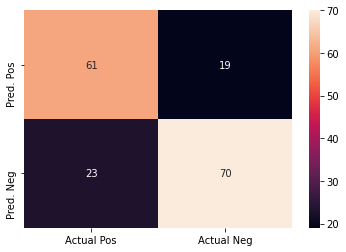

In [ ]:
valid_pred = sentiment_model.predict(validation_data[features])
tp = 0
fp = 0
tn = 0
fn = 0
for i in range(len(validation_data)):
  sentiment1 = validation_data.iloc[i]['sentiment']
  pred = valid_pred[i]
  if sentiment1 == 1 and pred == 1:
      tp = tp + 1
  elif sentiment1 == -1 and pred == 1:
      fp = fp + 1
  elif sentiment1 == -1 and pred == -1:
      tn = tn + 1
  else:
      fn = fn + 1
plot_confusion_matrix(tp, fp, fn, tn)
print(tp, fp, tn, fn)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(validation_data['sentiment'], valid_pred)
# 0.7572254335260116

0.7572254335260116

In [ ]:
import numpy as np
# TODO Fill in the loop
l2_penalties = [1, 4, 10, 1e2, 1e3, 1e5]
l2_penalty_names = ['coefficients [L2=1]', 'coefficients [L2=4]', 'coefficients [L2=10]', 
                    'coefficients [L2=1e2]', 'coefficients [L2=1e3]', 'coefficients [L2=1e5]']

# Add the coefficients to this table for each model
table = pd.DataFrame(columns = ['word'] + l2_penalty_names)
table['word'] = feature_names

for l2_penalty, column_name in zip(l2_penalties, l2_penalty_names):
    # TODO: Train the model and save the coefficients
    sentiment_model1 = LogisticRegression(penalty='l2', random_state = 1, C = 1/l2_penalty, fit_intercept = False)
    sentiment_model1.fit(train_data[features], train_data['sentiment'])
    coeff = sentiment_model1.coef_[0] 
    coeff_t = np.transpose(coeff)
    #print(coeff_t)
    table[column_name] = coeff_t
    
table.head()

,word,coefficients [L2=1],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
0,,0.039986,0.030585,0.027101,0.026085,0.019572,-0.000500
1,0,0.137539,0.108952,0.087795,0.029446,0.003514,0.000027
2,0000,0.045089,0.023882,0.013161,0.002196,0.000387,0.000005
3,002,-0.001951,-0.001644,-0.001362,-0.000672,-0.000173,-0.000004
4,004,-0.001951,-0.001644,-0.001362,-0.000672,-0.000173,-0.000004


In [ ]:
import pandas as pd
penal1 = table['coefficients [L2=1]']
posit = penal1.nlargest(5)
print(posit)
# 7620    1.370178
# 6538    1.305986
# 1693    1.213156
# 4598    1.170125
# 6056    1.050198
positive_words = pd.Series([table.iloc[7620]['word'], table.iloc[6538]['word'], table.iloc[1693]['word'], table.iloc[4598]['word'], table.iloc[6056]['word']])
print(positive_words)
#positive_words = table.nlargest(5, 'coefficients [L2=1]')['word']
#print(positive_words)
negt = penal1.nsmallest(5)
print(negt)
# 2501    -1.019372
# 4673    -0.919608
# 12961   -0.903901
# 9564    -0.900480
# 4657    -0.859525
negative_words = pd.Series([table.iloc[2501]['word'], table.iloc[4673]['word'], table.iloc[12961]['word'], table.iloc[9564]['word'], table.iloc[4657]['word']])
print(negative_words)
#negative_words = table.nsmallest(5, 'coefficients [L2=1]')['word']
#print(negative_words)

7620    1.370232
6538    1.305986
1693    1.213156
4598    1.170125
6056    1.050198
Name: coefficients [L2=1], dtype: float64
0        great
1         easy
2        Great
3         best
4    delicious
dtype: object
2501    -1.019372
4673    -0.919608
12961   -0.903961
9564    -0.900480
4657    -0.859525
Name: coefficients [L2=1], dtype: float64
0       Not
1     bland
2     tried
3       not
4    bitter
dtype: object


In [ ]:
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table[table['word'].isin(positive_words)]
    table_negative_words = table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, list(table_positive_words.iloc[i]),
                 '-', label=positive_words.iloc[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, list(table_negative_words.iloc[i]),
                 '-', label=negative_words.iloc[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -3, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

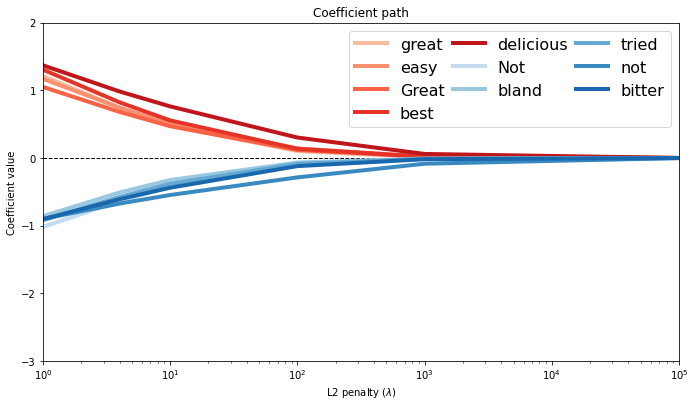

In [ ]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[1, 4, 10, 1e2, 1e3, 1e5])

In [ ]:
for l2_penalty, column_name in zip(l2_penalties, l2_penalty_names):
    # TODO: Train the model and save the coefficients
    modell = LogisticRegression(penalty = 'l2', random_state = 1, C = 1/l2_penalty, fit_intercept = False)
    modell.fit(train_data[features], train_data['sentiment'])
    accuracyy = accuracy_score(validation_data['sentiment'], modell.predict(validation_data[features]))
    print("l2 penalty is ")  
    print(l2_penalty)
    print("accuracy is ") 
    print(accuracyy)

l2 penalty is 
1
accuracy is 
0.7630057803468208
l2 penalty is 
4
accuracy is 
0.7687861271676301
l2 penalty is 
10
accuracy is 
0.7687861271676301
l2 penalty is 
100.0
accuracy is 
0.7687861271676301
l2 penalty is 
1000.0
accuracy is 
0.7109826589595376
l2 penalty is 
100000.0
accuracy is 
0.5317919075144508
